**Import các thư viện cần thiết** 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
import cv2
import glob 

hiển thị một hình ảnh

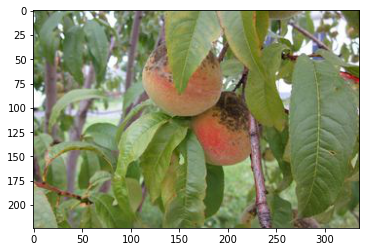

In [2]:

import matplotlib.pyplot as plt
plt.imshow(plt.imread("/content/drive/MyDrive/TranningSVM/Apple/1.jpg"))

Số lượng dữ liệu từng class cho training

In [3]:
data = []
labels = []

for folder in ['Apple','Jackfruit','Pomegranate','Pomelo','Tomato']:
    images = glob.glob('/content/drive/MyDrive/TranningSVM/%s/*.*'%folder)

    for i in range(len(images)): 
        image = cv2.imread(images[i])
        try : 
            data.append(image)
            labels.append(folder)
        except : 
            pass
    print(len(images),folder)

2726 Apple
2599 Jackfruit
2352 Pomegranate
2761 Pomelo
2620 Tomato


In [4]:
def Fruits(direc="/content/drive/MyDrive/TranningSVM"):
    fruits = []
    IMG_SIZE = 128
    categories = ['Pomelo', 'Tomato', 'Jackfruit', 'Apple', 'Pomegranate']
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num = categories.index(category)
        print(class_num)
        for image in os.listdir(path_link):
            images = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            resized_img = cv2.resize(images, (IMG_SIZE, IMG_SIZE))
            fruits.append([resized_img, class_num])
    return fruits

Fruits = Fruits()

0
1
2
3
4


In [5]:
X = []
y = []
for feature, label in Fruits:
    X.append(feature)
    y.append(label)

In [ ]:
len(X)

13058

In [6]:
X = np.array(X)
X = X.reshape(-1, 128, 128, 3)

In [7]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [8]:
y = np.array(y)
len(y)

13058

In [9]:
from sklearn.model_selection import train_test_split
seed = 20
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [10]:
len(X_train)

11752

In [11]:
len(X_test)

1306

In [13]:
valid_size=(0.2*13058)/(11752)
valid_size

0.2222260040844112

In [14]:

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=seed) # 0.25 x 0.8 = 0.2

In [15]:
len(X_train)

9140

In [16]:
len(X_test) # 10% testing

1306

In [17]:
len(X_valid) # 20% validating

2612

In [18]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping


In [19]:
from keras.preprocessing.image import ImageDataGenerator

In [20]:
train_generator = ImageDataGenerator(rescale = 1./255)

In [21]:
train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)

In [24]:
valid_generator = ImageDataGenerator(rescale=1/255)
test_generator=ImageDataGenerator(rescale=1/255)

In [25]:
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [26]:
valid_generator = valid_generator.flow(np.array(X_valid), y_valid, shuffle=False)

# Training

In [27]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))
vgg_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [28]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))
#eff_model.summary()
vgg_model.trainable = False

layer0 = tf.keras.layers.Flatten(name='flatten')(vgg_model.output)
layer1 = tf.keras.layers.Dense(4096, activation='relu',name='fc1')(layer0)
layer2 = tf.keras.layers.Dense(4096, activation='relu',name='fc2')(layer1)
out_layer = tf.keras.layers.Dense(5, activation='softmax')(layer2)
vgg_model = tf.keras.Model(vgg_model.input, out_layer)
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [29]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
vgg_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
             ]

In [30]:
history = vgg_model.fit(
    train_generator,
      epochs=15,
      verbose=1,
      validation_data = valid_generator,
      callbacks=callbacks)

Epoch 1/15
286/286 [==============================] - 56s 149ms/step - loss: 0.4429 - accuracy: 0.8363 - val_loss: 0.1921 - val_accuracy: 0.9326
Epoch 2/15
286/286 [==============================] - 38s 134ms/step - loss: 0.0719 - accuracy: 0.9778 - val_loss: 0.0693 - val_accuracy: 0.9763
Epoch 3/15
286/286 [==============================] - 39s 135ms/step - loss: 0.0143 - accuracy: 0.9970 - val_loss: 0.0417 - val_accuracy: 0.9851
Epoch 4/15
286/286 [==============================] - 39s 137ms/step - loss: 0.0211 - accuracy: 0.9929 - val_loss: 0.0343 - val_accuracy: 0.9900
Epoch 5/15
286/286 [==============================] - 39s 137ms/step - loss: 0.0421 - accuracy: 0.9856 - val_loss: 0.0759 - val_accuracy: 0.9705
Epoch 6/15
286/286 [==============================] - 39s 137ms/step - loss: 0.0334 - accuracy: 0.9892 - val_loss: 0.0662 - val_accuracy: 0.9789
Epoch 7/15
286/286 [==============================] - 39s 136ms/step - loss: 0.0097 - accuracy: 0.9965 - val_loss: 0.0975 - val_ac

# Đánh giá mô hình

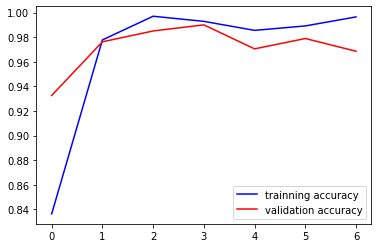

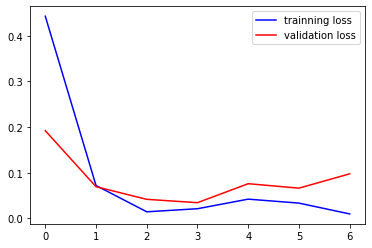

In [31]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.savefig("accuracy.png")
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.savefig("loss.png")
plt.show()

In [32]:
vgg_model.save("vggfruits.h5")

In [33]:
vgg_model.save("vggfruits.model")

INFO:tensorflow:Assets written to: vggfruits.model/assets


In [34]:
loss, accuracy = vgg_model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test: accuracy = 0.982389  ;  loss = 0.050855 


In [35]:
predict_x=vgg_model.predict(test_generator) 
classes_x=np.argmax(predict_x,axis=1)

In [36]:
classes_x

array([2, 4, 0, ..., 1, 4, 3])

In [37]:
labels_new = ['Pomelo', 'Tomato', 'Jackfruit', 'Apple', 'Pomegranate']

In [38]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), classes_x, target_names=labels_new))

              precision    recall  f1-score   support

      Pomelo       1.00      1.00      1.00       287
      Tomato       0.99      0.98      0.98       274
   Jackfruit       0.98      1.00      0.99       257
       Apple       0.99      0.95      0.97       272
 Pomegranate       0.95      0.98      0.97       216

    accuracy                           0.98      1306
   macro avg       0.98      0.98      0.98      1306
weighted avg       0.98      0.98      0.98      1306



In [51]:
labels_new = ['Pomelo', 'Tomato', 'Jackfruit', 'Apple', 'Pomegranate']
IMG_SIZE = 128
def prepare(filepath):
  #show ảnh test
    plt.imshow(plt.imread(filepath))
    plt.axis('off')
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255


    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
model = tf.keras.models.load_model("./vggfruits.h5")

0

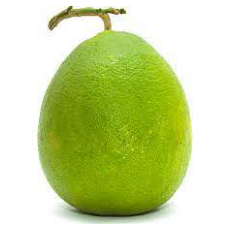

In [52]:
prediction = model.predict([prepare("/content/vggfruits.model/QUA BUOI.jpg")])
np.argmax(prediction)


3

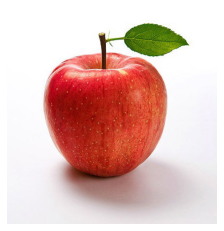

In [53]:
prediction = model.predict([prepare("/content/vggfruits.model/tao.jpg")])
np.argmax(prediction)
